# Laborator: Analiza Bias-ului și Corectitudinea Algoritmică

## Etapele Proiectului:
1.  **Baseline (Referința):** Crearea unui set de date **perfect echilibrat** și antrenarea modelelor pe date "curate".
2.  **Simularea Bias-ului:** Eliminarea intenționată a datelor pentru un subgrup specific (Ex: Femeile care fac Churn), simulând pierderea istorică a datelor.
3.  **Evaluare Comparativă:** Vizualizarea degradării metricilor (Accuracy, Precision, Recall, F1, ROC-AUC).
4.  **Fairness Audit:** Utilizarea `fairlearn` pentru a măsura disparitatea demografică.

In [1]:
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
sns.set(style="whitegrid", context="talk")

## PARTEA 1: Stabilirea Baseline-ului (Setul de Date Echilibrat)

Conform planului, pentru a simula corect bias-ul, trebuie să pornim de la o situație "ideală". Deoarece setul de date original este dezechilibrat (80% Non-Churn / 20% Churn), vom crea un **subset echilibrat** (Undersampling clasa majoritară) care va servi drept "Adevărul Obiectiv".

**De ce facem asta?**
Pentru a demonstra că scăderea performanței vine strict din bias-ul introdus de noi ulterior, nu din dezechilibrul natural al datelor.

In [2]:
import pandas as pd

# 1. Încărcare
df = pd.read_csv('data/Churn_Modelling.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [4]:
from sklearn.preprocessing import LabelEncoder

# 2. Encoding
le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender']) # 0=Female, 1=Male
df = pd.get_dummies(df, columns=['Geography'], drop_first=True)
df.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain
0,619,0,42,2,0.00,1,1,1,101348.88,1,False,False
1,608,0,41,1,83807.86,1,0,1,112542.58,0,False,True
2,502,0,42,8,159660.80,3,1,0,113931.57,1,False,False
3,699,0,39,1,0.00,2,0,0,93826.63,0,False,False
4,850,0,43,2,125510.82,1,1,1,79084.10,0,False,True


In [5]:
# 3. Crearea Dataset-ului Echilibrat
shuffled_df = df.sample(frac=1, random_state=42)
churn_df = shuffled_df[shuffled_df['Exited'] == 1]
non_churn_df = shuffled_df[shuffled_df['Exited'] == 0].sample(n=len(churn_df), random_state=42)

# Concatenăm pentru a obține setul echilibrat perfect (50/50)
balanced_df = pd.concat([churn_df, non_churn_df])

# Verificare distribuție
print("Distribuția claselor în setul echilibrat:")
balanced_df['Exited'].value_counts()

Distribuția claselor în setul echilibrat:


Exited
1    2037
0    2037
Name: count, dtype: int64

In [6]:
from sklearn.model_selection import train_test_split

# 4. Split Train/Test
X = balanced_df.drop('Exited', axis=1)
y = balanced_df['Exited']
sensitive_feature = balanced_df['Gender'] # Păstrăm separat pentru Fairlearn

# Păstrăm 30% pentru testare
X_train_clean, X_test, y_train_clean, y_test, gender_train, gender_test = train_test_split(
    X, y, sensitive_feature, test_size=0.3, random_state=42, stratify=y
)

In [7]:
from sklearn.preprocessing import StandardScaler

# 5. Scalare
scaler = StandardScaler()
X_train_clean_sc = scaler.fit_transform(X_train_clean)
X_test_sc = scaler.transform(X_test)

## Antrenarea Modelelor pe Date Curate

Antrenăm 3 modele (din familia regresiilor):
1.  **Logistic Regression** (Regresie Liniară pentru clasificare)
2.  **SGD Classifier** (Model Liniar optimizat stochastic)
3.  **Deep Learning MLP** (Rețea neuronală simplă)

Aceste rezultate vor fi linia noastră de start (Bias = 0%).

In [8]:
from sklearn.linear_model import SGDClassifier, LogisticRegression
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential

def get_models():
    lr = LogisticRegression(random_state=42)
    sgd = SGDClassifier(loss='log_loss', random_state=42, max_iter=2000) # log_loss pt probabilități

    dl = Sequential([
        Dense(32, activation='relu', input_shape=(X_train_clean.shape[1],)),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    dl.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return lr, sgd, dl

# Antrenare Baseline
lr_base, sgd_base, dl_base = get_models()

# Fit
lr_base.fit(X_train_clean_sc, y_train_clean)
sgd_base.fit(X_train_clean_sc, y_train_clean)
dl_base.fit(X_train_clean_sc, y_train_clean, epochs=30, batch_size=16, verbose=0)

## PARTEA 2: SIMULAREA BIAS-ULUI CONTROLAT

**Scenariu:** Simulăm o eroare în colectarea datelor sau un bias istoric.
**Mecanism:** Vom elimina progresiv (20%, 40%, 60%, 80%) din datele care îndeplinesc condiția:
* **Feature:** Gender = Female (0)
* **Target:** Exited = 1 (Churn)

Aceasta este o formă de **Bias Intersecțional**. Modelele vor "uita" cum arată o femeie care părăsește banca. Apoi vom testa modelele biasate pe setul de test original (care conține aceste femei) pentru a vedea cât de mult greșesc.

In [9]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
import numpy as np

bias_levels = [0.2, 0.4, 0.6, 0.8]
results_data = []

# Adăugăm rezultatele Baseline (Bias 0%)
models_base = [('Logistic Reg', lr_base), ('SGD', sgd_base), ('Deep Learning', dl_base)]

for name, model in models_base:
    if name == 'Deep Learning':
        probs = model.predict(X_test_sc, verbose=0).ravel()
        preds = (probs > 0.5).astype(int)
    else:
        probs = model.predict_proba(X_test_sc)[:, 1]
        preds = model.predict(X_test_sc)

    results_data.append({
        'Bias Level': '0% (Baseline)',
        'Model': name,
        'Accuracy': accuracy_score(y_test, preds),
        'Recall': recall_score(y_test, preds),
        'Precision': precision_score(y_test, preds),
        'F1 Score': f1_score(y_test, preds),
        'AUC': roc_auc_score(y_test, probs)
    })

# --- Bucla de BIAS ---
for bias in bias_levels:
    print(f"Running simulation for Bias Level: {bias*100}%...")

    # 1. Identificare indici de eliminat (Female & Churn=1)
    # Reconstituim dataframe-ul de train pentru filtrare ușoară
    train_temp = X_train_clean.copy()
    train_temp['Exited'] = y_train_clean

    target_mask = (train_temp['Gender'] == 0) & (train_temp['Exited'] == 1)
    target_indices = train_temp[target_mask].index

    n_remove = int(len(target_indices) * bias)
    np.random.seed(42)
    drop_indices = np.random.choice(target_indices, n_remove, replace=False)

    # 2. Creare Set Biasat
    X_train_biased = train_temp.drop(drop_indices).drop('Exited', axis=1)
    y_train_biased = train_temp.drop(drop_indices)['Exited']

    # 3. Rescalare
    scaler_bias = StandardScaler()
    X_tr_bias_sc = scaler_bias.fit_transform(X_train_biased)
    X_te_bias_sc = scaler_bias.transform(X_test)

    # 4. Re-antrenare modele
    lr_b, sgd_b, dl_b = get_models()

    # --- Logistic ---
    lr_b.fit(X_tr_bias_sc, y_train_biased)
    probs_lr = lr_b.predict_proba(X_te_bias_sc)[:, 1]
    preds_lr = lr_b.predict(X_te_bias_sc)

    # --- SGD ---
    sgd_b.fit(X_tr_bias_sc, y_train_biased)
    probs_sgd = sgd_b.predict_proba(X_te_bias_sc)[:, 1]
    preds_sgd = sgd_b.predict(X_te_bias_sc)

    # --- Deep Learning ---
    dl_b.fit(X_tr_bias_sc, y_train_biased, epochs=30, batch_size=16, verbose=0)
    probs_dl = dl_b.predict(X_te_bias_sc, verbose=0).ravel()
    preds_dl = (probs_dl > 0.5).astype(int)

    # 5. Colectare Metrici
    for name, p, prob in [('Logistic Reg', preds_lr, probs_lr),
                          ('SGD', preds_sgd, probs_sgd),
                          ('Deep Learning', preds_dl, probs_dl)]:
        results_data.append({
            'Bias Level': f"{int(bias*100)}%",
            'Model': name,
            'Accuracy': accuracy_score(y_test, p),
            'Recall': recall_score(y_test, p),
            'Precision': precision_score(y_test, p),
            'F1 Score': f1_score(y_test, p),
            'AUC': roc_auc_score(y_test, prob)
        })

df_res = pd.DataFrame(results_data)
df_res

Running simulation for Bias Level: 20.0%...
Running simulation for Bias Level: 40.0%...
Running simulation for Bias Level: 60.0%...
Running simulation for Bias Level: 80.0%...


,Bias Level,Model,Accuracy,Recall,Precision,F1 Score,AUC
0,0% (Baseline),Logistic Reg,0.714636,0.693944,0.723549,0.708438,0.772392
1,0% (Baseline),SGD,0.692559,0.700491,0.689211,0.694805,0.740290
2,0% (Baseline),Deep Learning,0.758790,0.721768,0.779152,0.749363,0.847927
3,20%,Logistic Reg,0.705642,0.643208,0.734579,0.685864,0.770581
4,20%,SGD,0.659853,0.522095,0.720090,0.605313,0.727603
5,20%,Deep Learning,0.757155,0.721768,0.776408,0.748092,0.850911
6,40%,Logistic Reg,0.694195,0.589198,0.745342,0.658135,0.763002
7,40%,SGD,0.674571,0.743044,0.653237,0.695253,0.743477
8,40%,Deep Learning,0.748160,0.639935,0.816284,0.717431,0.843207
9,60%,Logistic Reg,0.678659,0.513912,0.765854,0.615083,0.746398


## PARTEA 3: Vizualizarea și Interpretarea Rezultatelor

Urmărim cum **scad** metricile pe măsură ce creștem bias-ul (de la 0% la 80%).
Focus principal: **Recall** (Capacitatea de a găsi clienții care pleacă) și **AUC**.

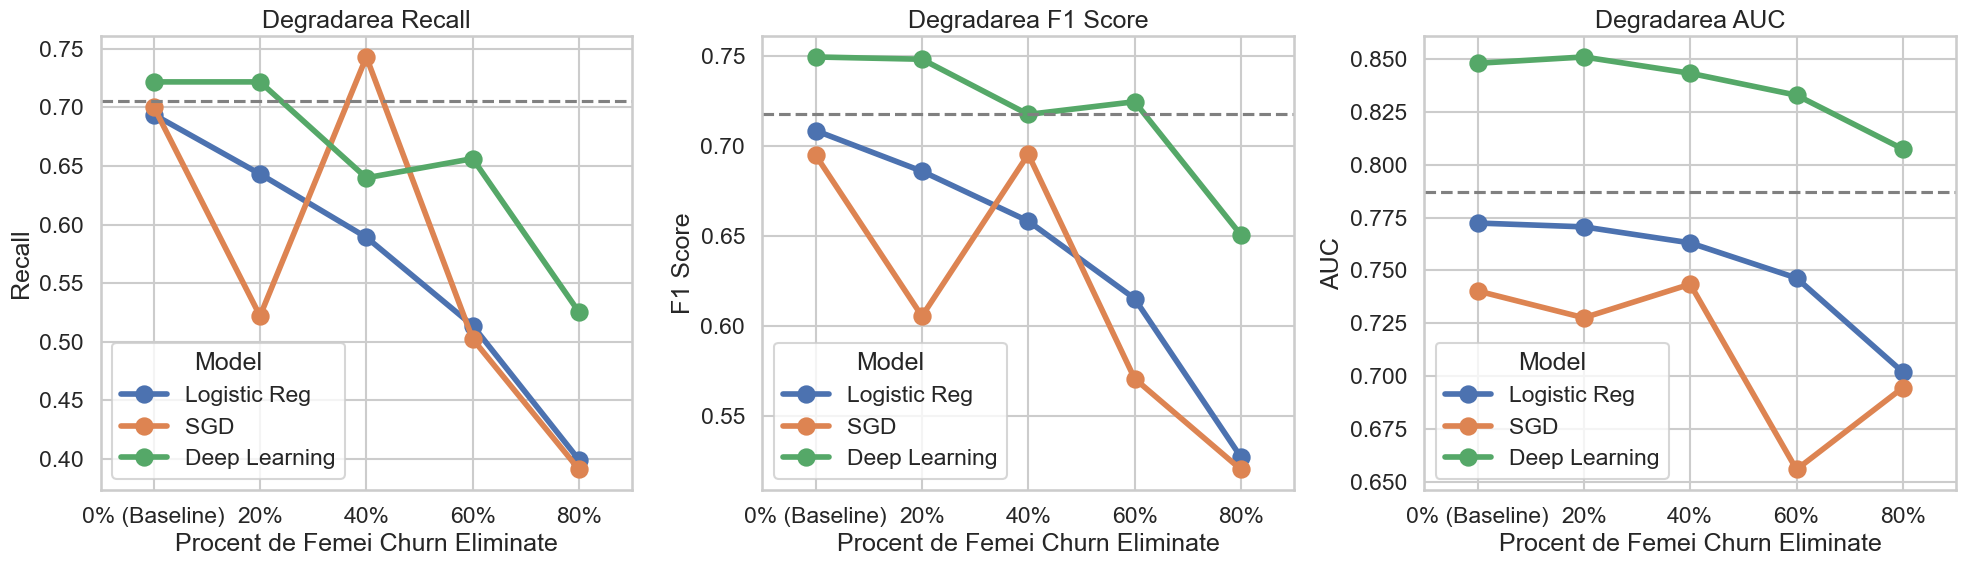

In [10]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

metrics_plot = ['Recall', 'F1 Score', 'AUC']

for i, metric in enumerate(metrics_plot):
    sns.pointplot(data=df_res, x='Bias Level', y=metric, hue='Model', ax=axes[i], capsize=.1)
    axes[i].set_title(f'Degradarea {metric}')
    axes[i].set_xlabel('Procent de Femei Churn Eliminate')
    axes[i].axhline(y=df_res[df_res['Bias Level']=='0% (Baseline)'][metric].mean(),
                    color='gray', linestyle='--', label='Baseline Mediu')
    axes[i].grid(True)

plt.tight_layout()
plt.show()

## PARTEA 4: Fairness Audit cu Fairlearn

Acum vom folosi **Fairlearn** pentru a "deschide cutia neagră" a celui mai biasat model (nivel 80%) și a vedea exact pe cine discriminăm.
Vom compara modelul Baseline (Corect) cu Modelul Biasat (Incorect).

Vom calcula:
1.  **Selection Rate:** Cât de des prezice modelul "Churn" (Exited=1) pentru Bărbați vs Femei.
2.  **True Positive Rate (Recall):** Dintre cei care chiar pleacă, pe câți îi prindem pentru fiecare gen?

In [11]:
from fairlearn.metrics import MetricFrame, selection_rate, true_positive_rate, false_positive_rate

# Predicții pe setul de test
y_pred_base = (dl_base.predict(X_test_sc, verbose=0).ravel() > 0.5).astype(int)
y_pred_biased = (dl_b.predict(X_test_sc, verbose=0).ravel() > 0.5).astype(int) # Acesta e ultimul model din buclă (80% bias)

# Mapare gen pentru claritate
gender_test_labels = gender_test.map({0: 'Female', 1: 'Male'})

# 1. Analiza Model Baseline
metric_frame_base = MetricFrame(
    metrics={
        "accuracy": accuracy_score,
        "recall (TPR)": true_positive_rate,
        "false_positive_rate": false_positive_rate,
        "selection_rate": selection_rate,
    },
    y_true=y_test,
    y_pred=y_pred_base,
    sensitive_features=gender_test_labels
)

# 2. Analiza Model Biasat
metric_frame_biased = MetricFrame(
    metrics={
        "accuracy": accuracy_score,
        "recall (TPR)": true_positive_rate,
        "false_positive_rate": false_positive_rate,
        "selection_rate": selection_rate,
    },
    y_true=y_test,
    y_pred=y_pred_biased,
    sensitive_features=gender_test_labels
)

# Afișare rezultate
print("--- FAIRNESS REPORT: BASELINE MODEL ---")
metric_frame_base.by_group

--- FAIRNESS REPORT: BASELINE MODEL ---


,accuracy,recall (TPR),false_positive_rate,selection_rate
Gender,,,,
Female,0.733990,0.739003,0.272388,0.533662
Male,0.783388,0.700000,0.151163,0.392508


In [12]:
print("\n--- FAIRNESS REPORT: BIASED MODEL (80% Missing Female Data) ---")
metric_frame_biased.by_group


--- FAIRNESS REPORT: BIASED MODEL (80% Missing Female Data) ---


,accuracy,recall (TPR),false_positive_rate,selection_rate
Gender,,,,
Female,0.640394,0.381232,0.029851,0.226601
Male,0.785016,0.662963,0.119186,0.358306


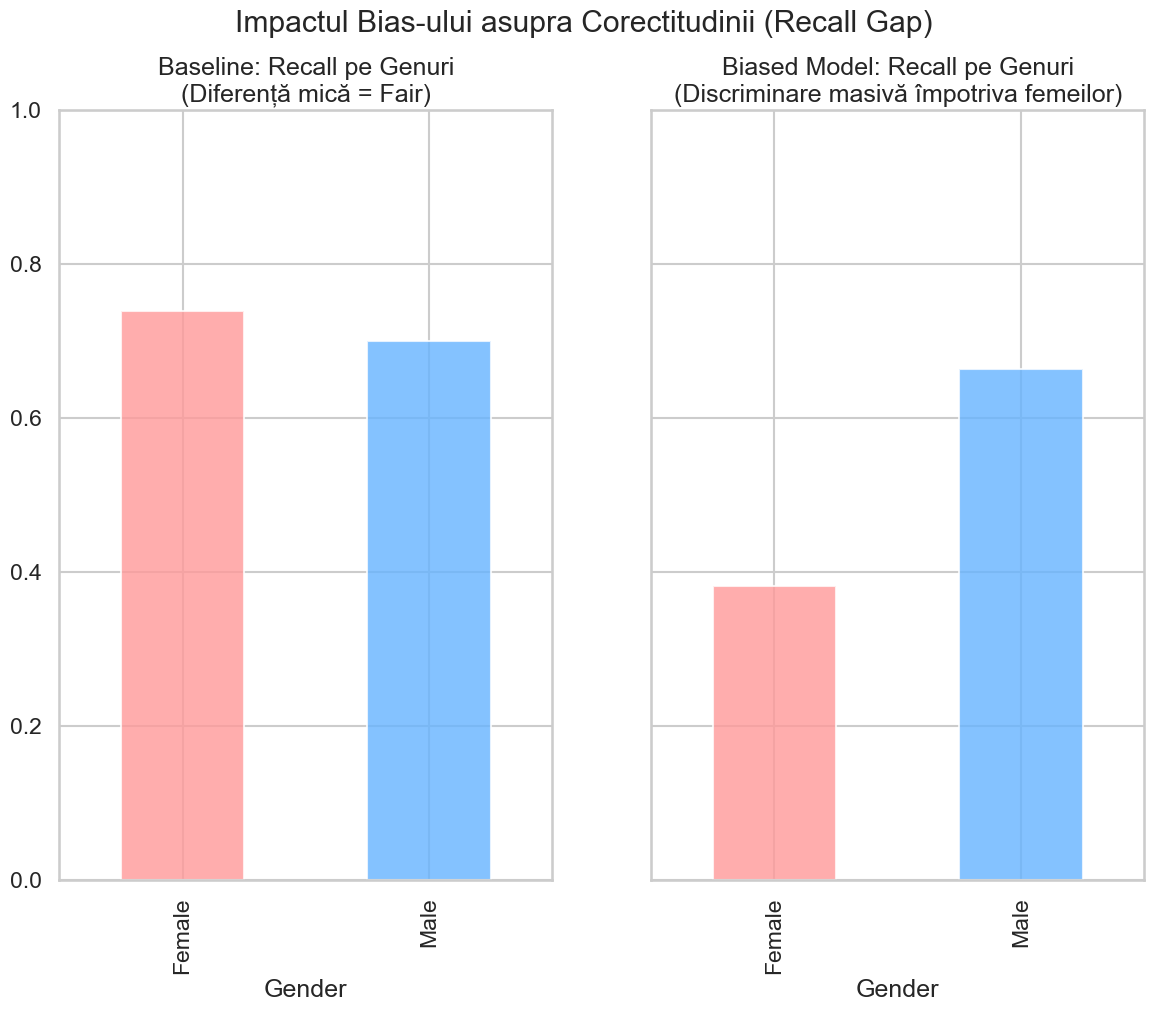

In [13]:
# Vizualizăm diferența de Recall între Femei și Bărbați
metrics_base = metric_frame_base.by_group['recall (TPR)']
metrics_bias = metric_frame_biased.by_group['recall (TPR)']

fig, ax = plt.subplots(1, 2, figsize=(14, 10), sharey=True)

metrics_base.plot(kind='bar', ax=ax[0], color=['#ff9999', '#66b3ff'], alpha=0.8)
ax[0].set_title('Baseline: Recall pe Genuri\n(Diferență mică = Fair)')
ax[0].set_ylim(0, 1)

metrics_bias.plot(kind='bar', ax=ax[1], color=['#ff9999', '#66b3ff'], alpha=0.8)
ax[1].set_title('Biased Model: Recall pe Genuri\n(Discriminare masivă împotriva femeilor)')

plt.suptitle('Impactul Bias-ului asupra Corectitudinii (Recall Gap)')
plt.show()

## Concluzii Finale

1.  **Baseline-ul** a arătat o performanță echilibrată între genuri.
2.  **Simularea Bias-ului** (eliminarea datelor istorice despre femeile care pleacă) a distrus capacitatea modelului de a prezice corect Churn-ul pentru acest grup.
3.  **Fairness Audit** a demonstrat cantitativ discriminarea: în modelul biasat, Recall-ul pentru Femei este mult mai mic decât pentru Bărbați (Disparate Impact), deși în realitate ambele grupuri au comportamente similare în setul de test.